# TCB - Loan Approval Analysis

## Overview
Taichung Commercial Bank ("TCB") is a commercial bank in Taiwan and it was estabished in 1953. One of the services they offer is commercial loans to companies. Underwriters assess the financials of a company to determine if a loan should be granted. This process is quite strenuous as many factors go into the review. 

TCB has reached out to understand the most important variables when granting loans. They want to see if the process can be shorted/streamlined. 

The Taiwan Economic Journal has bankruptcy data from 1999–2009. This data will be used to determine what features indicate a company is about to go bankrupt, as it would not be wise to loan money to a firm that has poor financials. This analysis will also determine the most important financial features a company needs to have, to be approved for a loan.

## Importing Libraries

In [1]:
# Data manipulation and visualization
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Success metrics for models
from sklearn.metrics import accuracy_score,precision_score,recall_score, confusion_matrix,f1_score,roc_curve,roc_auc_score
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from imblearn.over_sampling import SMOTE 
import shap
from sklearn.inspection import permutation_importance
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel

# Algorithms for supervised learning methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Filtering the future warnings
import warnings
warnings.filterwarnings('ignore')

## Obtaining & Understanding the Data

Data was taken from [kaggle.com](https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction). It has financial information on 6,800 companies and if they declared bankruptcy between 1999 and 2009. As per the report, company bankruptcy is defined based on the business regulations of the Taiwan Stock Exchange. Company industries include manufacturing, shipping, tourism, retail, and others. It does not include companies in the financial industry.

This data will be helpful in understanding what factors are indicators a company will go bankrupt and what factors TCB should prioritize.

In [2]:
# Download the datset by following the below steps. "#" indicates the step and "##" indicates the code. 

# Install Kaggle
## !pip install kaggle

# Create a directory
## !mkdir ~/.kaggle

# Copy the download into the file 
## !cp /Users/skaur/Downloads/kaggle.json /Users/skaur/.kaggle/kaggle.json

# Download the dataset from kaggle
## ! kaggle datasets download -d fedesoriano/company-bankruptcy-prediction

# Unzip file
## import zipfile
## with zipfile.ZipFile("company-bankruptcy-prediction.zip", 'r') as zip_ref:
##     zip_ref.extractall()

In [7]:
# Read data from csv file & create dataframe. Preview first 10 rows.
df = pd.read_csv('data.csv')
df.head(10)

Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          
5          1                                           0.388680          
6          0                                           0.390923          
7          0                                           0.508361          
8          0                                           0.488519          
9          0                                           0.495686          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   
5                                 0.415177   
6                                 0.445704   
7                                 0.570922   
8                                 0.545137   
9                                 0.550916   

    ROA(B) before interest and depreciation after tax  \
0                                           0.405750    
1                                           0.516730    
2                                           0.472295    
3                                           0.457733    
4                                           0.522298    
5                                           0.419134    
6                                           0.436158    
7                                           0.559077    
8                                           0.543284    
9                                           0.542963    

    Operating Gross Margin   Realized Sales Gross Margin  \
0                 0.601457                      0.601457   
1                 0.610235                      0.610235   
2                 0.601450                      0.601364   
3                 0.583541                      0.583541   
4                 0.598783                      0.598783   
5                 0.590171                      0.590251   
6                 0.619950                      0.619950   
7                 0.601738                      0.601717   
8                 0.603612                      0.603612   
9                 0.599209                      0.599209   

    Operating Profit Rate   Pre-tax net Interest Rate  \
0                0.998969                    0.796887   
1                0.998946                    0.797380   
2                0.998857                    0.796403   
3                0.998700                    0.796967   
4                0.998973                    0.797366   
5                0.998758                    0.796903   
6                0.998993                    0.797012   
7                0.999009                    0.797449   
8                0.998961                    0.797414   
9                0.999001                    0.797404   

    After-tax net Interest Rate   Non-industry income and expenditure/revenue  \
0                      0.808809                                      0.302646   
1                      0.809301                                      0.303556   
2                      0.808388                                      0.302035   
3                      0.808966                                      0.303350   
4                      0.809304                                      0.303475   
5                      0.808771                                      0.303116   
6                      0.808960                                      0.302814   
7                      0.809362                                      0.303545   
8                      0.809338    

In [8]:
# Assess dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

The links below provide further information on the financial ratios in the dataframe. 
* [Corporate Financial Institute - Financial Ratios](https://corporatefinanceinstitute.com/resources/accounting/financial-ratios/)
* [Investopedia - ROA](https://www.investopedia.com/ask/answers/031215/what-formula-calculating-return-assets-roa.asp)
* [Wealthy Education - Ultimate Financial Ratios List](https://wealthyeducation.com/financial-ratio-categories/)

In [9]:
# Get shape to determine number of rows & columns
df.shape

(6819, 96)

In [10]:
# Get descriptive statistics on the dataframe
df.describe().T

count      mean  \
Bankrupt?                                           6819.0  0.032263   
 ROA(C) before interest and depreciation before...  6819.0  0.505180   
 ROA(A) before interest and % after tax             6819.0  0.558625   
 ROA(B) before interest and depreciation after tax  6819.0  0.553589   
 Operating Gross Margin                             6819.0  0.607948   
...                                                    ...       ...   
 Liability to Equity                                6819.0  0.280365   
 Degree of Financial Leverage (DFL)                 6819.0  0.027541   
 Interest Coverage Ratio (Interest expense to E...  6819.0  0.565358   
 Net Income Flag                                    6819.0  1.000000   
 Equity to Liability                                6819.0  0.047578   

                                                         std  min       25%  \
Bankrupt?                                           0.176710  0.0  0.000000   
 ROA(C) before interest and depreciation before...  0.060686  0.0  0.476527   
 ROA(A) before interest and % after tax             0.065620  0.0  0.535543   
 ROA(B) before interest and depreciation after tax  0.061595  0.0  0.527277   
 Operating Gross Margin                             0.016934  0.0  0.600445   
...                                                      ...  ...       ...   
 Liability to Equity                                0.014463  0.0  0.276944   
 Degree of Financial Leverage (DFL)                 0.015668  0.0  0.026791   
 Interest Coverage Ratio (Interest expense to E...  0.013214  0.0  0.565158   
 Net Income Flag                                    0.000000  1.0  1.000000   
 Equity to Liability                                0.050014  0.0  0.024477   

                                                         50%       75%  max  
Bankrupt?                                           0.000000  0.000000  1.0  
 ROA(C) before interest and depreciation before...  0.502706  0.535563  1.0  
 ROA(A) before interest and % after tax             0.559802  0.589157  1.0  
 ROA(B) before interest and depreciation after tax  0.552278  0.584105  1.0  
 Operating Gross Margin                             0.605997  0.613914  1.0  
...                                                      ...       ...  ...  
 Liability to Equity                                0.278778  0.281449  1.0  
 Degree of Financial Leverage (DFL)                 0.026808  0.026913  1.0  
 Interest Coverage Ratio (Interest expense to E...  0.565252  0.565725  1.0  
 Net Income Flag                                    1.000000  1.000000  1.0  
 Equity to Liability                                0.033798  0.052838  1.0  

[96 rows x 8 columns]

* Numeric values are scaled in the range of 0-1. There are low standard deviations and close mean & median values.
* Net Income Flag column seems to contain only one value, "1.0".

## Data Prep
This section prepares the data for EDA and modeling. It will check for missing values, suplicate values and if there are rows with only a single value. 

In [ ]:
# Check for missing values
df.isnull().values.any() 

In [11]:
# Check for duplicate values
df.duplicated().any()

False

In [12]:
# Drop columns that only have one value
for col in df:
    if(len(df.loc[:,col].unique()) == 1):
        df.pop(col)

In [13]:
# Recheck dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 95 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

## Explanatory Data Analysis ("EDA")

### Correlation Matrix For Numeric Features

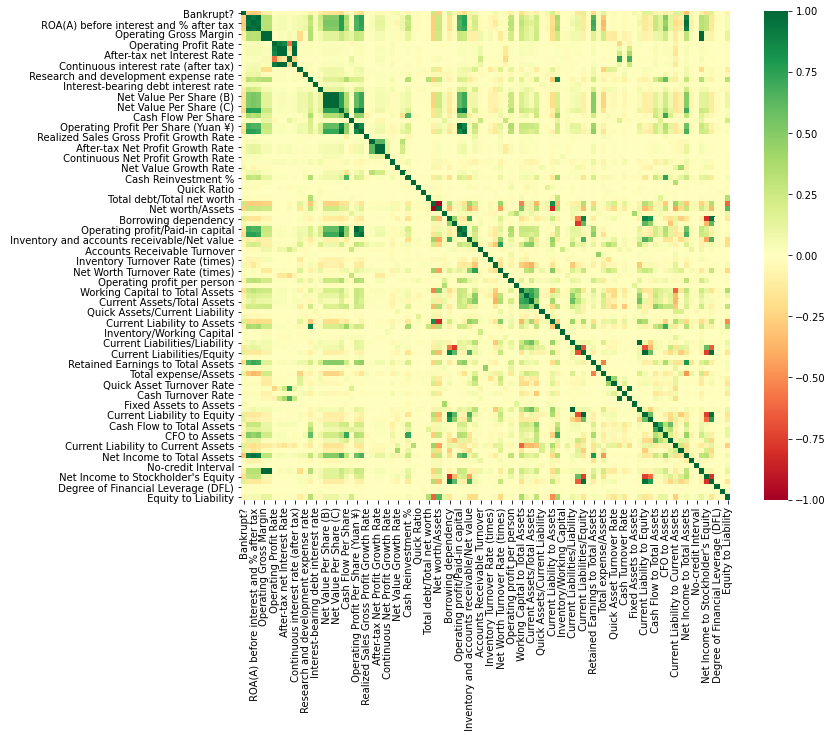

In [14]:
# Plot correlation matrix
corrmat = df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, square=True,cmap='RdYlGn');
plt.show();

* Most variables seem to have a neutral correlation.
* There are a handful of variables that have strong correlations, which may cause implications for modeling.

### Dropping Highly-Correlated Features
* Dropping features that have a correlation of 0.9 or above. 

In [15]:
print("The original dataframe has {} columns.".format(df.shape[1]))
# Calculate the correlation matrix and take the absolute value
corr_matrix = df.corr().abs()

# Create a True/False mask and apply it
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)

# List column names of highly correlated features (r > 0.90)
to_drop = [c for c in tri_df.columns if any(tri_df[c] >  0.90)]
reduced_df = df.drop(to_drop, axis=1) # Drop the features
print("The reduced dataframe has {} columns.".format(reduced_df.shape[1]))

The original dataframe has 95 columns.
The reduced dataframe has 75 columns.


20 columns were dropped from the dataframe.

### "Bankrupt?" Feature Analysis
Bankrupt is the dependent variable for this analysis. It is important for TCB to factor this into their analysis as:
* It would be financially beneficial to correctly predict of a client is about to go bankrupt. 
* It would be very costly if the model predicts a company won't go bankrupt. The bank would grant them a loan, they would declare bankruptcy shortly after and it would fall back on TCB.
* Falsely predicting a company will go bankrupt would keep potential business away from the bank. 

0    6599
1     220
Name: Bankrupt?, dtype: int64

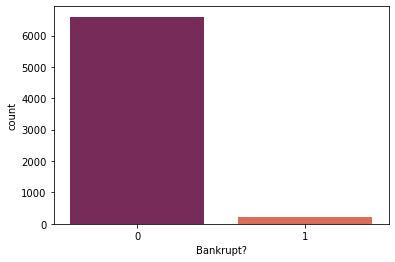

In [16]:
# Plot countplot for Bankrupt? feature
sns.countplot(data=df,x='Bankrupt?',palette="rocket");
df['Bankrupt?'].value_counts()

* The data seems to be very imbalanced. 
* Only 3.23% of companies in the dataset declared bankruptcy.  

### Train-Test Split
* The dataset is split into test-train parts to be able to use in ML algorithms.
* 75% for training and 25% for testing

In [17]:
X=reduced_df.drop(['Bankrupt?'],axis=1)
y=reduced_df['Bankrupt?']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=123)

### Applying SMOTE to Resolve Imbalanced 'Bankrupt?' Feature
* SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.
* The technique aims to balance class distribution by randomly increasing minority class examples by replicating them.

In [18]:
# Check record counts in the Bankrupt? column
reduced_df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

In [19]:
# Apply technique
sm = SMOTE(k_neighbors=5, random_state=123)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)
print('Before OverSampling, the shape of X_train: {}'.format(X_train.shape))
print('Before OverSampling, the shape of y_train: {}'.format(y_train.shape)) 
print('After OverSampling, the shape of X_train_over: {}'.format(X_train_over.shape))
print('After OverSampling, the shape of y_train_over: {}'.format(y_train_over.shape))

Before OverSampling, the shape of X_train: (5114, 74)
Before OverSampling, the shape of y_train: (5114,)
After OverSampling, the shape of X_train_over: (9882, 74)
After OverSampling, the shape of y_train_over: (9882,)


In [20]:
# Recheck record counts
y_train_over.value_counts()

1    4941
0    4941
Name: Bankrupt?, dtype: int64

In [21]:
churn = reduced_df['Bankrupt?'].value_counts()
transuction = churn.index
quantity = churn.values

# draw pie circule with plotly
figure = px.pie(y_train_over,
               values = quantity,
               names = transuction,
               hole = .5,
               title = 'Distribution of Bankruptcy - Before SMOTE')
figure.show()

In [22]:
y_train_over_df = y_train_over.to_frame()
churn = y_train_over_df['Bankrupt?'].value_counts()
transuction = churn.index
quantity = churn.values

# draw pie circule with plotly
figure = px.pie(y_train_over_df,
               values = quantity,
               names = transuction,
               hole = .5,
               title = 'Distribution of Bankruptcy - After SMOTE')
figure.show()

## Modeling Part I - Finding a Good Model
This section is dedicated to running a few different algorithms and finding the best performing one. 

### Model 1 - Logistic Regression Classifier
* Logistic regression is a supervised learning technique and it is used to predict the probability of a binary (yes/no) event occurring.
* The target variable is categorical in nature. In other words, it belongs to one class or another and has a value of eiher 0 or 1.
* This model will serve as the baseline model.

In [23]:
# Object creation
lr= LogisticRegression() 

# Fit the data into the algorithm
lr.fit(X_train_over,y_train_over) 

# Get the predictions
y_pred_lr = lr.predict(X_test) 

**************** LOGISTIC REGRESSION CLASSIFIER - BASELINE MODEL RESULTS ****************
Accuracy score for testing set:  0.72845
F1 score for testing set:  0.08317
Recall score for testing set:  0.44681
Precision score for testing set:  0.04585


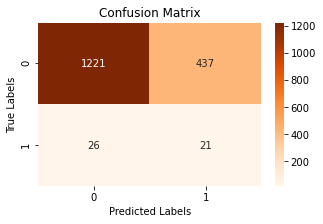

In [24]:
# Print results
print("**************** LOGISTIC REGRESSION CLASSIFIER - BASELINE MODEL RESULTS ****************")
print('Accuracy score for testing set: ',round(accuracy_score(y_test,y_pred_lr),5))
print('F1 score for testing set: ',round(f1_score(y_test,y_pred_lr),5))
print('Recall score for testing set: ',round(recall_score(y_test,y_pred_lr),5))
print('Precision score for testing set: ',round(precision_score(y_test,y_pred_lr),5))
cm_lr = confusion_matrix(y_test, y_pred_lr)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm_lr, annot=True, cmap='Oranges', fmt='g', ax=ax);
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['0', '1']) ; ax.yaxis.set_ticklabels(['0', '1'])
plt.show();

### Model 2 - KNN Classifier
* The K-Nearest Neighbor ("KNN") creates an imaginary boundary to classify the data. As new points come in, the algorithm will try to predict that to the nearest of the boundary line.
* It assumes there is similarity between the new case & available cases and will put the new case into the category that is most similar to the available categories.

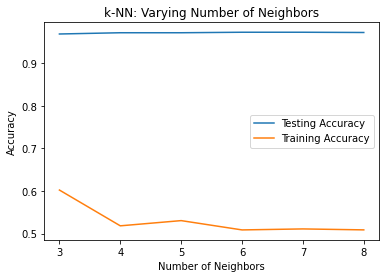

In [25]:
# Plot line graph to determine which K-value has the highest testing accuracy
neighbors = np.arange(3, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    train_accuracy[i] = knn.score(X_train_over,y_train_over)
    test_accuracy[i] = knn.score(X_test, y_test)
    
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

* The code above created 9 models for each K-value, from 3 to 9, and showed the training and testing accuracies for each K.
* From the plot, a K-value needs to be chosen. It cannot be too high and must have the highest accury for both testing and training sets. As the K-value gets higher, the model gets more complicated and requires more computational power and time.
* According to the plot, a K-value of 5 or 6 looks good.

<Figure size 432x288 with 0 Axes>

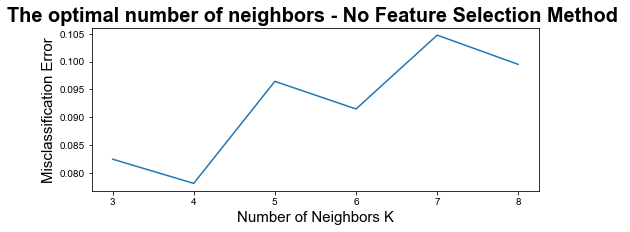

In [26]:
k_list = list(range(3,9,1))
cv_scores = []

for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_over, y_train_over, cv=3, scoring='accuracy')
    cv_scores.append(scores.mean())
  
MSE = [1 - x for x in cv_scores]

plt.figure()
plt.figure(figsize=(8,3))
plt.title('The optimal number of neighbors - No Feature Selection Method ', fontsize=20, fontweight='bold')
plt.xlabel('Number of Neighbors K', fontsize=15)
plt.ylabel('Misclassification Error', fontsize=15)
sns.set_style("whitegrid")
plt.plot(k_list, MSE)

plt.show()

In [27]:
#K=3 and p=2
knn =KNeighborsClassifier(n_neighbors=3,p=2) 
knn_model = knn.fit(X_train,y_train) 
y_pred_knn = knn.predict(X_test)

**************** KNN MODEL RESULTS ****************
Accuracy score for testing set:  0.96891
F1 score for testing set:  0.10169
Recall score for testing set:  0.06383
Precision score for testing set:  0.25


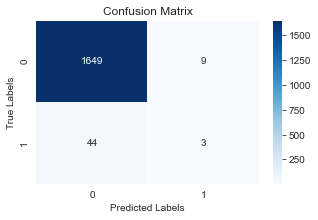

In [28]:
print("**************** KNN MODEL RESULTS ****************")
print('Accuracy score for testing set: ',round(accuracy_score(y_test,y_pred_knn),5))
print('F1 score for testing set: ',round(f1_score(y_test,y_pred_knn),5))
print('Recall score for testing set: ',round(recall_score(y_test,y_pred_knn),5))
print('Precision score for testing set: ',round(precision_score(y_test,y_pred_knn),5))
cm_knn = confusion_matrix(y_test, y_pred_knn)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm_knn, annot=True, cmap='Blues', fmt='g', ax=ax);
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['0', '1']) ; ax.yaxis.set_ticklabels(['0', '1'])
plt.show();

### Model 3 - Random Forest Classifier
* Random forest classifier is an ensemble machine learning algorithm.
* A forest is comprised of trees. The more trees it has, the more robust the forest is. Random forest creates decision trees on randomly selected data samples, gets prediction from each tree and then, selects the best solution by means of voting.

In [29]:
rf_model = RandomForestClassifier() 
rf_model.fit(X_train_over,y_train_over)
y_pred_rf = rf_model.predict(X_test)

**************** RANDOM FOREST MODEL RESULTS ****************
Accuracy score for testing set:  0.96657
F1 score for testing set:  0.4466
Recall score for testing set:  0.48936
Precision score for testing set:  0.41071


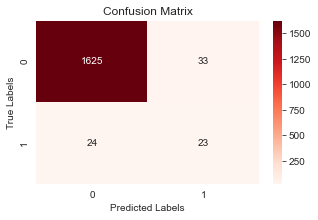

In [30]:
print("**************** RANDOM FOREST MODEL RESULTS ****************")
print('Accuracy score for testing set: ',round(accuracy_score(y_test,y_pred_rf),5))
print('F1 score for testing set: ',round(f1_score(y_test,y_pred_rf),5))
print('Recall score for testing set: ',round(recall_score(y_test,y_pred_rf),5))
print('Precision score for testing set: ',round(precision_score(y_test,y_pred_rf),5))
cm_rf = confusion_matrix(y_test, y_pred_rf)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm_rf, annot=True, cmap='Reds', fmt='g', ax=ax);
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['0', '1']) ; ax.yaxis.set_ticklabels(['0', '1'])
plt.show();

### Model 4 - Decision Tree Classifier
* Decision Tree is a Supervised learning technique that can be used for both classification and Regression problems, but mostly it is preferred for solving Classification problems. It is a tree-structured classifier, where internal nodes represent the features of a dataset, branches represent the decision rules and each leaf node represents the outcome.
* It is called a decision tree because, similar to a tree, it starts with the root node, which expands on further branches and constructs a tree-like structure.

In [31]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_over,y_train_over)
y_pred_dt = decision_tree.predict(X_test)

**************** DECISION TREE CLASSIFIER MODEL RESULTS **************** 
Accuracy score for testing set:  0.94194
F1 score for testing set:  0.25564
Recall score for testing set:  0.3617
Precision score for testing set:  0.19767


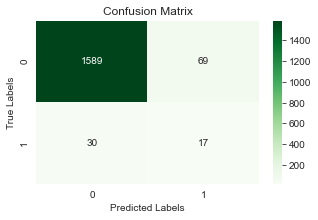

In [32]:
print("**************** DECISION TREE CLASSIFIER MODEL RESULTS **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test,y_pred_dt),5))
print('F1 score for testing set: ',round(f1_score(y_test,y_pred_dt),5))
print('Recall score for testing set: ',round(recall_score(y_test,y_pred_dt),5))
print('Precision score for testing set: ',round(precision_score(y_test,y_pred_dt),5))
cm_dt = confusion_matrix(y_test, y_pred_dt)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm_dt, annot=True, cmap='Greens', fmt='g', ax=ax);
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['0', '1']) ; ax.yaxis.set_ticklabels(['0', '1']);
plt.show();

### Model 5 - MLP Classifier
* MLP Classifier stands for Multi-layer Perceptron classifier. 
* It is a feedforward artificial neural network model that maps input data sets to a set of appropriate outputs. An MLP consists of multiple layers and each layer is fully connected to the following one.
* The underlying neural network performs the task of classification.

In [33]:
mlp = MLPClassifier()
mlp.fit(X_train_over,y_train_over)
y_pred_mlp = mlp.predict(X_test)

**************** MULTILAYER PERCEPTRON CLASSIFIER MODEL RESULTS **************** 
Accuracy score for testing set:  0.87801
F1 score for testing set:  0.10345
Recall score for testing set:  0.25532
Precision score for testing set:  0.06486


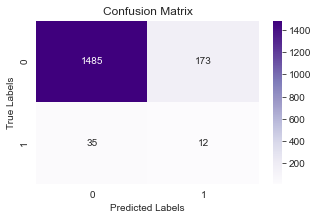

In [34]:
print("**************** MULTILAYER PERCEPTRON CLASSIFIER MODEL RESULTS **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test,y_pred_mlp),5))
print('F1 score for testing set: ',round(f1_score(y_test,y_pred_mlp),5))
print('Recall score for testing set: ',round(recall_score(y_test,y_pred_mlp),5))
print('Precision score for testing set: ',round(precision_score(y_test,y_pred_mlp),5))
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm_mlp, annot=True, cmap='Purples', fmt='g', ax=ax);
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['0', '1']) ; ax.yaxis.set_ticklabels(['0', '1']);
plt.show();

## Model Comparison

### ROC Curve

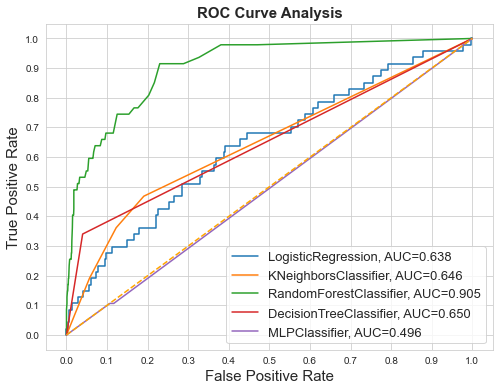

In [35]:
classifiers = [LogisticRegression(),KNeighborsClassifier(n_neighbors=3,p=2),RandomForestClassifier(),
              DecisionTreeClassifier(),MLPClassifier()]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train_over, y_train_over)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

* The ROC curve illustrates the true positive rate against the false positive rate of the classifier. 
* The best performing model will have a curve that hugs the upper left of the graph, which is the Random Forest Classifier in this case. 
* The Random Forest Classifier has the highest AUC value, at 0.904. In translation, it will make accurate predictions 90.4% of the time.

### F1 Score

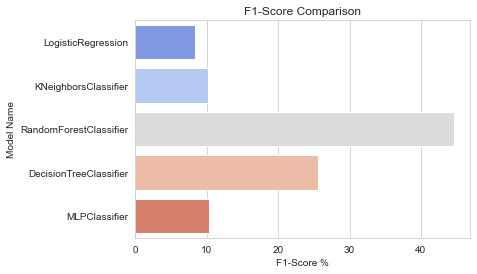

In [36]:
models = [lr,knn_model,rf_model,decision_tree,mlp]

result = []
results = pd.DataFrame(columns= ["Models","F1Score"])

for model in models:
    names = model.__class__.__name__
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)    
    result = pd.DataFrame([[names, f1*100]], columns= ["Models","F1Score"])
    results = results.append(result)
    
    
sns.barplot(x= 'F1Score', y = 'Models', data=results, palette="coolwarm")
plt.xlabel('F1-Score %')
plt.ylabel('Model Name')
plt.title('F1-Score Comparison');

In [37]:
results.sort_values(by="F1Score",ascending=False)

Models    F1Score
0  RandomForestClassifier  44.660194
0  DecisionTreeClassifier  25.563910
0           MLPClassifier  10.344828
0    KNeighborsClassifier  10.169492
0      LogisticRegression   8.316832

* F1 score is the harmonic mean of precision and recall. 
* It is the best metric to use in this case as there was a severe class imbalance. 
* The model with the highest F1-score is the Random Forest Classifier. 

### Modeling Comments
* In total, five different models were ran. 
* F1-score was used as the performance metric to assess model performance as it is the best metric for imbalanced data. 
* In relationship to the underwriters at TCB, it is most important for the model to identify the true postitives and the true negatives. 
    * This is clients who are in good financial standing and deserve a loan. They should be granted one as it will bring business to the bank.
    * This is also clients who don't have the best financials and may be on their way to bankruptcy. It wouldn't be a good idea to loan them money.
* The best performing model was the Random Forest Classifier.

## Modeling Part II - Further Analysis on the Chosen Model
This section will analyze the chosen model. Shap values and a permutation plot will be created to understand why the model made the conclusions that it did. The chosen model will also go through hyperparameter tuning.

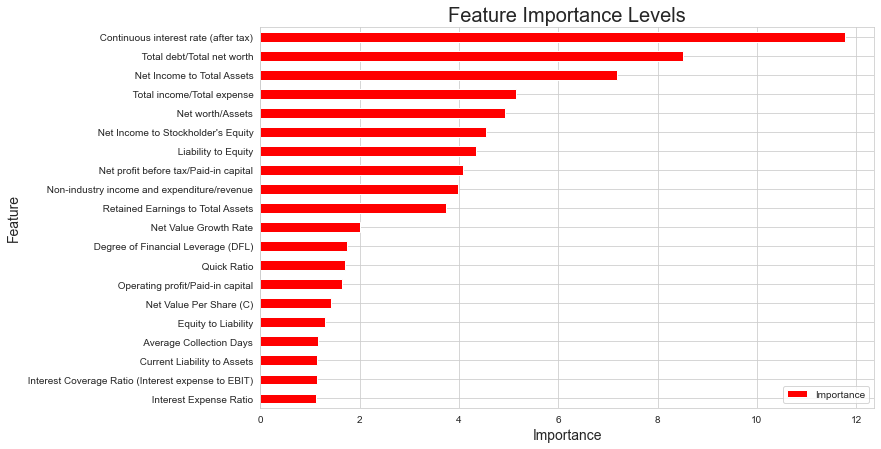

In [38]:
# Plot 20 most important features from the Random Forest model
Importance =pd.DataFrame({"Importance": rf_model.feature_importances_*100},index = X_train_over.columns)
Importance.sort_values(by = "Importance", axis = 0, ascending = True).tail(20).plot(kind ="barh", color = "r",figsize=(11, 7))
plt.title("Feature Importance Levels",size=20);
plt.xlabel('Importance',size=14)
plt.ylabel('Feature',size=14)
plt.show()

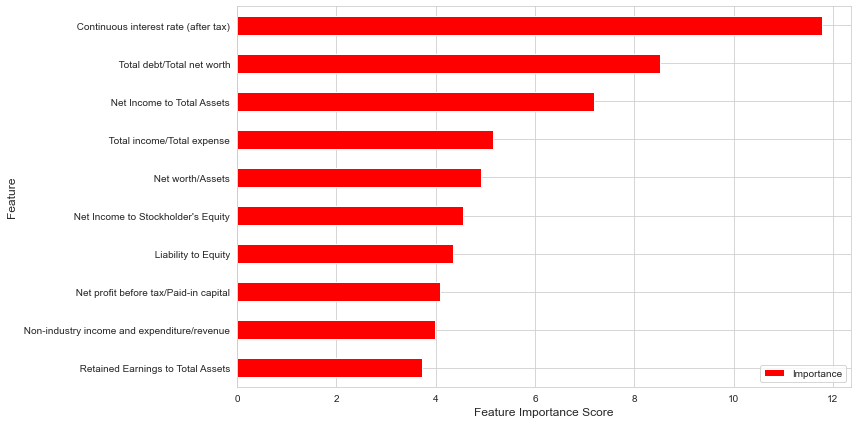

In [52]:
# Plot 20 most important features from the Random Forest model
Importance =pd.DataFrame({"Importance": rf_model.feature_importances_*100},index = X_train_over.columns)
Importance.sort_values(by = "Importance", axis = 0, ascending = True).tail(10).plot(kind ="barh", color = "r",figsize=(11, 7))
plt.xlabel('Feature Importance Score',size=12);
plt.ylabel('Feature',size=12)
plt.show()

### Explainable AI Section ("XAI")

In [39]:
# Commenting this out due to lengthy runtime.

# explainer = shap.TreeExplainer(rf_model)
# shap_values = explainer.shap_values(X_train_over, approximate=False, check_additivity=False)
# shap.summary_plot(shap_values[1], X_train_over)

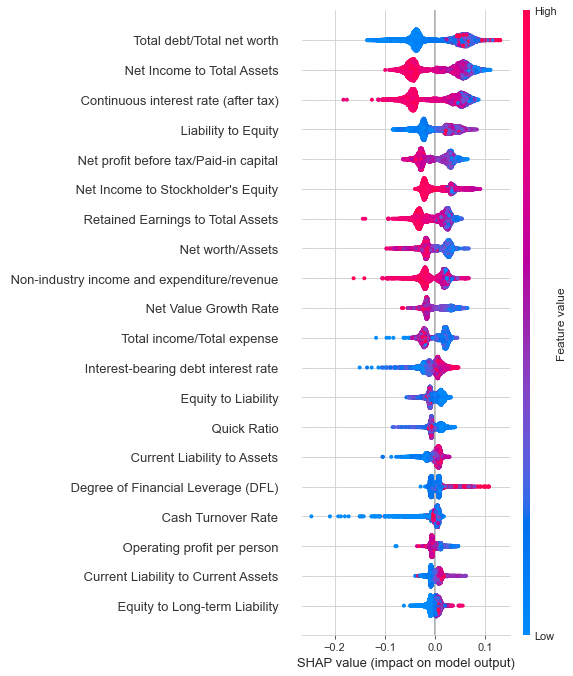

* SHAP stands for Shapley Additive exPlanations. It deconstructs a prediction into a sum of contributions from each of the model's input variables. SHAP estimates the impact a feature has on the predictions a model will make. 
* The summary plot above shows the SHAP value corresponding to each feature for every instance it shows up in the model.
* According to the plot, some of the variables with the highest value are Net Income to Total Assets, Continuous interest rate, Retained Earnings to Total Assets and Non-industry income & expenditure/revenue.

### Permutation Importance

In [40]:
perm = PermutationImportance(rf_model, random_state=1).fit(X_train_over, y_train_over)
eli5.show_weights(perm, feature_names = X_train_over.columns.tolist())

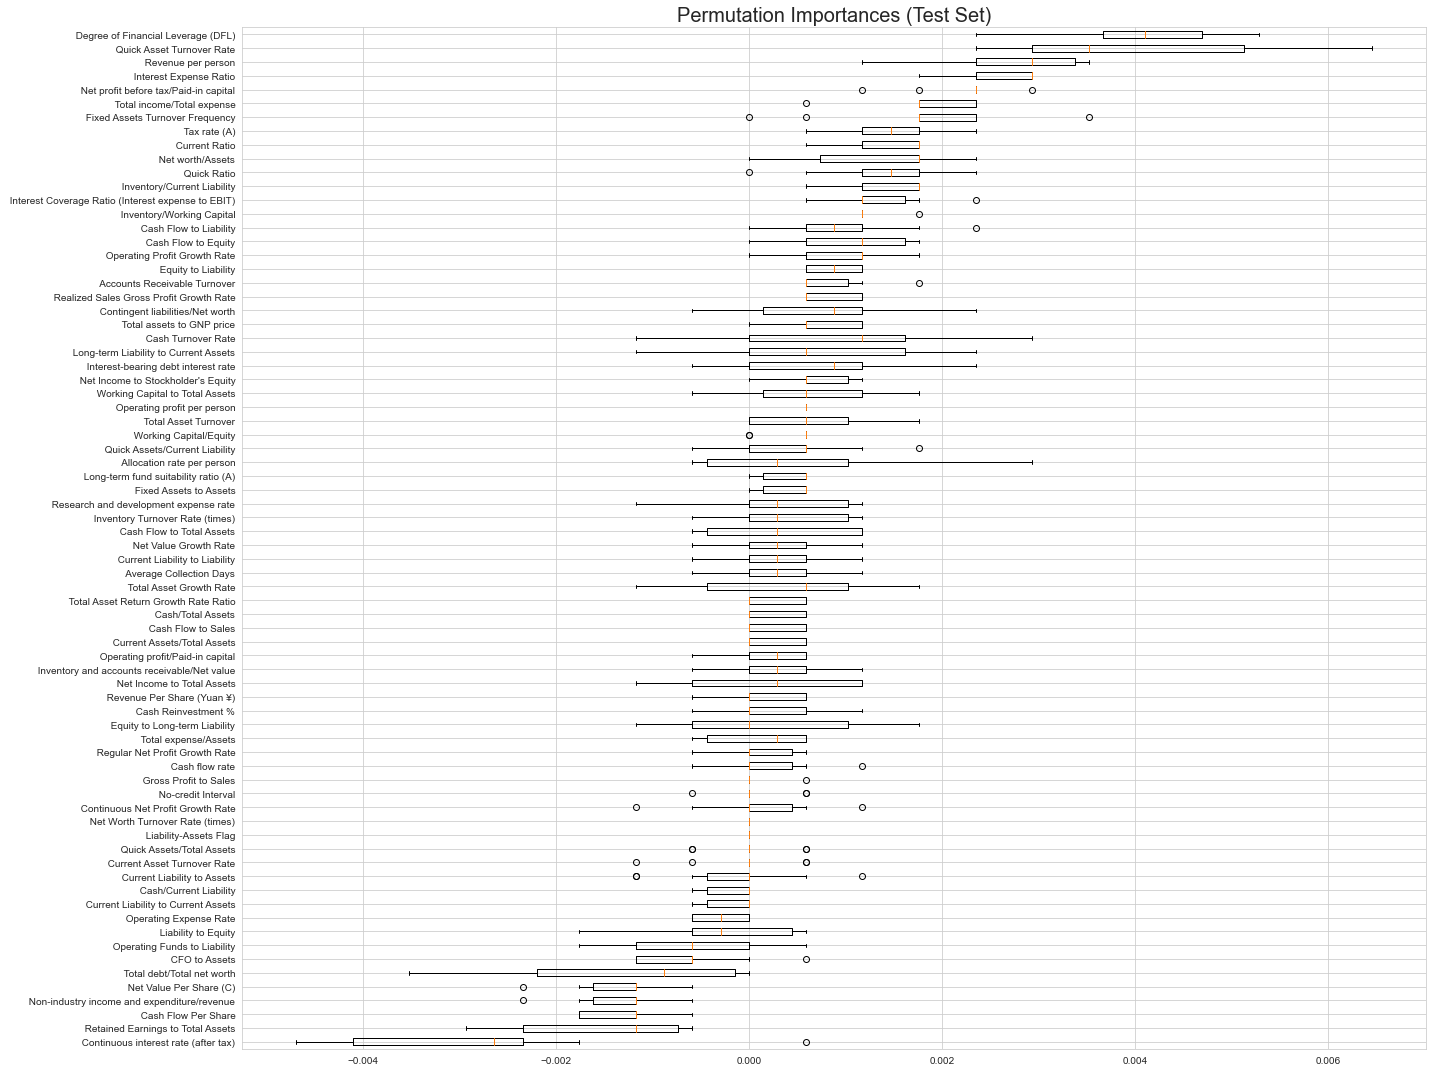

In [41]:
result = permutation_importance(rf_model, X_test.iloc[:,0:], y_test, n_repeats=10,random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(20,15))
ax.boxplot(result.importances[sorted_idx].T,vert=False, labels=X_test.iloc[:,0:].columns[sorted_idx])
ax.set_title("Permutation Importances (Test Set)", size=20)
fig.tight_layout()
plt.show()

* Feature permutation importances is a model-agnostic technique which estimates the impact of a feature on a trained model.
* It allows one to identify the features that have the biggest impact on a model’s predictions for model diagnostics and improvement.
* According to the plot, Interest Expense Ratio had the highest impact and Continuous interest rate had the lowest.

### Hyperparameter Tuning of Random Forest Classifier

In [42]:
rf_params = {"max_depth": [5,8,10,12],
             "max_features":[5,8,10,12],
             "n_estimators":[500,750,1000],
             "min_samples_split":[5,10,15],
             "criterion":['gini','entropy']}

In [43]:
# Commenting this out due to lengthy runtime.

# rf_model2 = RandomForestClassifier()
# rf_cv_model = GridSearchCV(rf_model2,rf_params,cv=5,verbose=False)
# rf_cv_model.fit(X_train_over,y_train_over)
# print("Best parameters:"+str(rf_cv_model.best_params_))

The best parameters were:
* max_depth=12
* max_features=8
* n_estimators=750
* min_samples_split=10
* criterion='gini'                                      

### Feature Selection - Select From Model
* The SelectFromModel is a meta-estimator that determines the weight importance of features by comparing them to the given threshold value. 


In [44]:
sfm = SelectFromModel(estimator = RandomForestClassifier(n_estimators=750, max_features=8, max_depth=12,
                                                         min_samples_split=10,criterion='gini'), prefit=False,
                                                         max_features=20,threshold='median')
sfm.fit(X,y)
feature_idx = sfm.get_support()
feature_names = X.columns[feature_idx]
feature_names[0:20]

Index([' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)',
       ' Interest-bearing debt interest rate', ' Net Value Per Share (C)',
       ' Net Value Growth Rate', ' Interest Expense Ratio',
       ' Total debt/Total net worth', ' Net worth/Assets',
       ' Net profit before tax/Paid-in capital',
       ' Working Capital to Total Assets', ' Cash/Total Assets',
       ' Working Capital/Equity', ' Retained Earnings to Total Assets',
       ' Total income/Total expense', ' Net Income to Total Assets',
       ' Net Income to Stockholder's Equity', ' Liability to Equity',
       ' Degree of Financial Leverage (DFL)',
       ' Interest Coverage Ratio (Interest expense to EBIT)',
       ' Equity to Liability'],
      dtype='object')

In [45]:
X_sfm_selected = sfm.transform(X)
X_sfm_selected

array([[3.02646434e-01, 7.80984850e-01, 7.25072507e-04, ...,
        2.66006308e-02, 5.64050112e-01, 1.64687409e-02],
       [3.03556430e-01, 7.81505974e-01, 6.47064706e-04, ...,
        2.64576820e-01, 5.70174946e-01, 2.07943063e-02],
       [3.02035177e-01, 7.80283936e-01, 7.90079008e-04, ...,
        2.65547199e-02, 5.63706076e-01, 1.64741143e-02],
       ...,
       [3.03512199e-01, 7.81546395e-01, 0.00000000e+00, ...,
        2.67911567e-02, 5.65158396e-01, 9.76487375e-02],
       [3.03498181e-01, 7.81663308e-01, 2.11021102e-04, ...,
        2.68220477e-02, 5.65301507e-01, 4.40094472e-02],
       [3.13415329e-01, 7.86079039e-01, 5.90000000e+08, ...,
        2.67929526e-02, 5.65166944e-01, 2.33902238e-01]])

In [46]:
X_train_sfm,X_test_sfm,y_train_sfm,y_test_sfm = train_test_split(X_sfm_selected,y,test_size=0.2,random_state=42)

In [47]:
model_rf_sfm = RandomForestClassifier(n_estimators=750, max_features=8, max_depth=12,min_samples_split=10,criterion='gini')
model_rf_sfm.fit(X_train_sfm,y_train_sfm)
y_pred_rf_sfm = model_rf_sfm.predict(X_test_sfm)

**************** SelectFromModel TECHNIQUE APPLIED RANDOM FOREST MODEL RESULTS **************** 
Accuracy score for testing set:  0.96701
F1 score for testing set:  0.34783
Recall score for testing set:  0.23529
Precision score for testing set:  0.66667


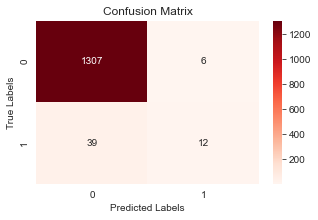

In [48]:
print("**************** SelectFromModel TECHNIQUE APPLIED RANDOM FOREST MODEL RESULTS **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test_sfm,y_pred_rf_sfm),5))
print('F1 score for testing set: ',round(f1_score(y_test_sfm,y_pred_rf_sfm),5))
print('Recall score for testing set: ',round(recall_score(y_test_sfm,y_pred_rf_sfm),5))
print('Precision score for testing set: ',round(precision_score(y_test_sfm,y_pred_rf_sfm),5))
cm_rf_sfm = confusion_matrix(y_test_sfm, y_pred_rf_sfm)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm_rf_sfm, annot=True, cmap='Reds', fmt='g', ax=ax);
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['0', '1']) ; ax.yaxis.set_ticklabels(['0', '1'])
plt.show();

* The F1-Score for the hypertuned model is lower than the original Random Forest model ran. 
* Model hyptertuning doesn't guarantee performace will improve. 

## Conclusions

The loan approving process at Taichung Commercial Bank is a lengthy one. Underwriters reached out to see if the process could be improved or shortened. 

Bankruptcy data was taken from the Taiwan Economic Journal and various different algorithms were ran. The Random Forest Classifier model had the highest F1-Score. That model was then further analyzed to understand why the model chose the features it did. Hypeparameter tuning was also performed however, it did not increase model performance.

Some thoughts/suggestions:
* **Seperate clients into Red, Amber and Green buckets.** These buckets would be the result of an initial financial analysis and it would be based on if the client has a good financial standing in the top 10 features.
    * The "Red" bucket will be clients who have not met the thresholds for the top 10 features and therefore would immediately be rejected. 
    * The "Amber" bucket applies to clients who may not meet all of the top 10 features and therefore require some further work.
    * The "Green" bucket applies to clients who have meet all of the top 10 features as those hold the most weight in the model. 
* **Review client history.** It would be insightful to understand how the client has performed over the last 10 years. This initial test will show the trajectory the client has been on and may raise red flags, if any.